In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
BASELINE_500_PATH = "ruoyu/Random_Sampling_500.csv"
BASELINE_1000_PATH = "ruoyu/Random_Sampling_1000.csv"
R_half_PATH = "ruoyu/Shekhar_0.4 to 1_Equal_opportunity.csv"
L_half_PATH = "lawrence/equal_oppo_Shekhar.csv"

## Read data

In [3]:
baseline_500 = pd.read_csv(BASELINE_500_PATH)
baseline_500.columns = ['index', 'test_error', 'demographic parity',
       'equal_opportunity', 'equal odds', 'overall accuracy violation']
baseline_500 = baseline_500.mean()
baseline_1000 = pd.read_csv(BASELINE_1000_PATH)
baseline_1000.columns = ['index', 'test_error', 'demographic parity',
       'equal_opportunity', 'equal odds', 'overall accuracy violation']
baseline_1000 = baseline_1000.mean()
R_half = pd.read_csv(R_half_PATH)
L_half = pd.read_csv(L_half_PATH)

In [4]:
baseline_1000

index                         4.500000
test_error                    0.166574
demographic parity            0.188759
equal_opportunity             0.131623
equal odds                    0.188759
overall accuracy violation    0.196374
dtype: float64

# Process Data

In [5]:
if 'Abernethy' in R_half_PATH:
    assert('Abernethy' in L_half_PATH)
    R_half = R_half[R_half['p'] > 0.5]
    R_half.columns = ['index', 'p', 'checkpoint', 'test_error', 'demographic parity',
       'equal_opportunity', 'equal odds', 'overall accuracy violation']
    L_half = L_half[L_half['p'] <= 0.5]
    L_half.columns = ['index', 'p', 'checkpoint', 'test_error', 'demographic parity',
       'equal odds', 'equal_opportunity', 'overall accuracy violation']
    
elif 'Shekhar' in R_half_PATH:
    assert('Shekhar' in L_half_PATH)
    R_half = R_half[R_half['C'] > 0.5]
    R_half.columns = ['index', 'C', 'checkpoint', 'test_error', 'demographic parity',
       'equal_opportunity', 'equal odds', 'overall accuracy violation']
    L_half = L_half[L_half['C'] <= 0.5]
    L_half.columns = ['index', 'C', 'checkpoint', 'test_error', 'demographic parity',
       'equal odds', 'equal_opportunity', 'overall accuracy violation']
else:
    assert(False)

In [6]:
df = L_half.append(R_half)
df

,index,C,checkpoint,test_error,demographic parity,equal odds,equal_opportunity,overall accuracy violation
0,0,0.0,500.0,0.184064,0.229548,0.355329,0.225180,0.136940
1,1,0.0,1000.0,0.197211,0.335748,0.563952,0.338448,0.163099
2,0,0.0,500.0,0.199668,0.156768,0.205585,0.118275,0.150131
3,1,0.0,1000.0,0.181474,0.130787,0.153133,0.099117,0.132493
4,0,0.0,500.0,0.184064,0.119008,0.039850,0.009034,0.126367
...,...,...,...,...,...,...,...,...
255,255,1.0,1000.0,0.170518,0.213325,0.213325,0.143713,0.196374
256,256,1.0,500.0,0.183267,0.198172,0.198172,0.127431,0.196374
257,257,1.0,1000.0,0.170186,0.201787,0.201787,0.135169,0.196374
258,258,1.0,500.0,0.181076,0.197345,0.197345,0.130456,0.196374


In [7]:
df_per_checkpoint = {}
parameter = None
if 'p' in df.columns:
    parameter = 'p'
elif 'C' in df.columns:
    parameter = 'C'
else:
    assert(False)
    
for checkpoint in df['checkpoint'].unique():
    tmp_df = df[df['checkpoint'] == checkpoint]
    mean_list = []
    
    for i in df[parameter].unique():
        tmp = tmp_df[abs(tmp_df[parameter] - i) < 1e-6].values[:,1:]
        mean_list.append(np.mean(tmp, axis=0))
    
    if parameter == 'p':
        df_per_checkpoint[f'checkpoint_{int(checkpoint)}'] = pd.DataFrame(mean_list, columns=['p', 'checkpoint', 'test_error', 'demographic parity',
                'equal odds', 'equal_opportunity', 'overall accuracy violation'])
    elif parameter == 'C':
        df_per_checkpoint[f'checkpoint_{int(checkpoint)}'] = pd.DataFrame(mean_list, columns=['C', 'checkpoint', 'test_error', 'demographic parity',
                'equal odds', 'equal_opportunity', 'overall accuracy violation'])
    else:
        assert(False)

# Plot function

In [8]:
metric_list = ['demographic parity', 'equal odds', 'equal_opportunity', 'overall accuracy violation']

def make_plot(
    x_var:str,
    y_var_const:str,
    df_dict,
):
    #########
    # df_dict: dictionary['checkpoint_500' : dataframe]
    #########
    for key, val in df_dict.items():
        sorted_df = val.sort_values(x_var)
        for metric in metric_list:
            x_list = []
            y_list = []
            r_list = []
            
            x_best = sorted_df[x_var].iloc[0]
            y_best = sorted_df[metric].iloc[0]
            
            x_list.append(x_best)
            y_list.append(y_best)
            if 'p' in sorted_df.columns:
                r_list.append(sorted_df['p'].iloc[0])
            elif 'C' in sorted_df.columns:
                r_list.append(sorted_df['C'].iloc[0])
            
            for i in range(1, len(sorted_df)):
                cur_y = sorted_df[metric].iloc[i]
                if cur_y <= y_best:
                    cur_x = sorted_df[x_var].iloc[i]
                    y_best = cur_y
                    x_best = cur_x
                    
                    x_list.append(x_best)
                    y_list.append(y_best)
                    if 'p' in sorted_df.columns:
                        r_list.append(sorted_df['p'].iloc[i])
                    elif 'C' in sorted_df.columns:
                        r_list.append(sorted_df['C'].iloc[i])
            
            tmp_fig = plt.figure()
            tmp_fig = plt.plot(x_list, y_list)
            sc = plt.scatter(x_list, y_list, c = r_list)
            tmp_fig = plt.colorbar(sc)
            plt.xlabel(x_var)
            plt.ylabel(metric)
            plt.title(f"{x_var} vs {metric} ({key})")
            if '500' in key:
                plt.scatter(baseline_500[x_var], baseline_500[metric], marker='x')
            elif '1000' in key:
                plt.scatter(baseline_1000[x_var], baseline_1000[metric], marker='x')
            plt.savefig(f"{x_var} vs {metric} ({key})___Train_On_{y_var_const}")
    
    
    

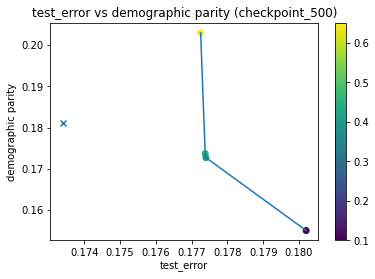

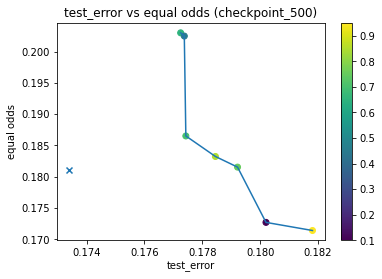

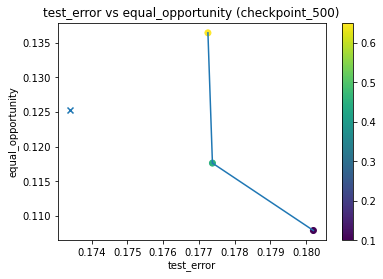

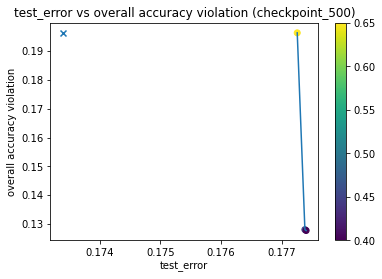

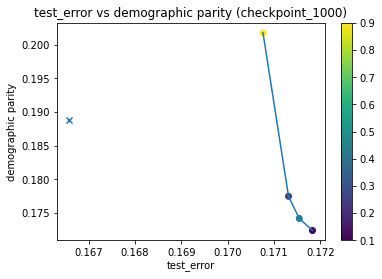

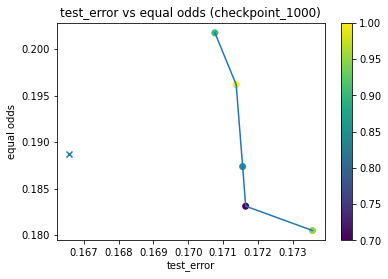

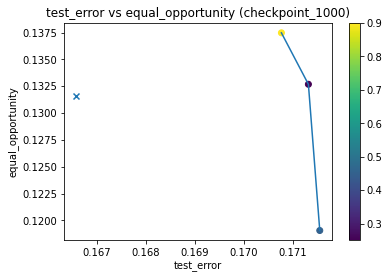

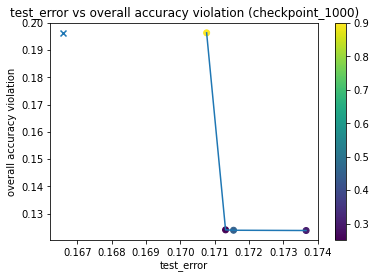

In [9]:
make_plot('test_error', 'Shekhar_Equal_Opportunity', df_per_checkpoint)